In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 9s - loss: 0.0311

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 604ms/step - loss: 0.0215
Average validation loss: 0.6775281429290771
4/4 [==============================] - 5s 617ms/step - loss: 0.0215 - val_loss: 0.6775
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 607ms/step - loss: 0.0143 - val_loss: 0.6775
Average validation loss: 0.5549880862236023
4/4 [==============================] - 8s 618ms/step - loss: 0.0143 - val_loss: 0.6163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 611ms/step - loss: 0.0103 - val_loss: 0.6163
Average validation loss: 0.41922569274902344
4/4 [==============================] - 10s 622ms/step - loss: 0.0103 - val_los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 700ms/step - loss: 6.0107e-07
Average validation loss: 0.08647073805332184
8/8 [==============================] - 6s 711ms/step - loss: 6.0107e-07 - val_loss: 0.0865
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 726ms/step - loss: 5.8341e-07 - val_loss: 0.0865
Average validation loss: 0.09367993474006653
8/8 [==============================] - 12s 739ms/step - loss: 5.8341e-07 - val_loss: 0.0901
Epoch 3/10
8/8 [==============================] - 17s 697ms/step - loss: 5.7439e-07 - val_loss: 0.0901
Average validation loss: 0.005759631283581257
8/8 [==============================] - 17s 707ms/step - loss: 5.7439e-07 - val_loss: 0.0620
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segfor

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 718ms/step - loss: 2.1504e-06
Average validation loss: 0.2526336021643753
12/12 [==============================] - 9s 731ms/step - loss: 2.1504e-06 - val_loss: 0.2526
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 705ms/step - loss: 2.2014e-06 - val_loss: 0.2526
Average validation loss: 0.07722690365214173
12/12 [==============================] - 17s 716ms/step - loss: 2.2014e-06 - val_loss: 0.1649
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 709ms/step - loss: 2.2249e-06 - val_loss: 0.1649
Average validation loss: 0.10719312479098637
12/12 [==============================] - 26

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 736ms/step - loss: 1.0869e-06
Average validation loss: 0.06910818861797452
16/16 [==============================] - 12s 746ms/step - loss: 1.0869e-06 - val_loss: 0.0691
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 691ms/step - loss: 1.0298e-06 - val_loss: 0.0691
Average validation loss: 0.07032689651168766
16/16 [==============================] - 23s 702ms/step - loss: 1.0298e-06 - val_loss: 0.0697
Epoch 3/10
16/16 [==============================] - 34s 686ms/step - loss: 9.7759e-07 - val_loss: 0.0697
Average validation loss: 0.04701039404608309
16/16 [==============================] - 34s 697ms/step - loss: 9.7759e-07 - val_loss: 0.0621
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weig

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 723ms/step - loss: 4.9627e-07
Average validation loss: 0.052735721319913866
20/20 [==============================] - 15s 733ms/step - loss: 4.9627e-07 - val_loss: 0.0527
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 705ms/step - loss: 4.8444e-07 - val_loss: 0.0527
Average validation loss: 0.05314330458641052
20/20 [==============================] - 29s 716ms/step - loss: 4.8444e-07 - val_loss: 0.0529
Epoch 3/10
20/20 [==============================] - 43s 701ms/step - loss: 5.0282e-07 - val_loss: 0.0529
Average validation loss: 0.06369772180914879
20/20 [==============================] - 43s 711ms/step - loss: 5.0282e-07 - val_loss: 0.0565
Epoch 4/10
20/20 [==============================] - 57s 695ms/step - loss: 4.9074e-07 - val_loss: 0.0565
Average validati

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 705ms/step - loss: 8.2808e-07
Average validation loss: 0.09372467547655106
24/24 [==============================] - 17s 715ms/step - loss: 8.2808e-07 - val_loss: 0.0937
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 708ms/step - loss: 7.6897e-07 - val_loss: 0.0937
Average validation loss: 0.0662299854060014
24/24 [==============================] - 35s 719ms/step - loss: 7.6897e-07 - val_loss: 0.0800
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 702ms/step - loss: 6.8884e-07 - val_loss: 0.0800
Average validation loss: 0.049739220490058265
24/24 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 706ms/step - loss: 2.0703e-06
Average validation loss: 0.06588852740824222
40/40 [==============================] - 29s 717ms/step - loss: 2.0703e-06 - val_loss: 0.0659
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 56s 691ms/step - loss: 1.5713e-06 - val_loss: 0.0659
Average validation loss: 0.07770815417170525
40/40 [==============================] - 57s 700ms/step - loss: 1.5713e-06 - val_loss: 0.0718
Epoch 3/10
40/40 [==============================] - 84s 689ms/step - loss: 1.4388e-06 - val_loss: 0.0718
Average validation loss: 0.0691649729385972
40/40 [==============================] - 85s 699ms/step - loss: 1.4388e-06 - val_loss: 0.0709
Epoch 4/10
40/40 [==============================] - 112s 690ms/step - loss: 1.2941e-06 - val_loss: 0.0709
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 700ms/step - loss: 7.7995e-07
Average validation loss: 0.03754787511813144
48/48 [==============================] - 34s 710ms/step - loss: 7.7995e-07 - val_loss: 0.0375
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 68s 704ms/step - loss: 5.9147e-07 - val_loss: 0.0375
Average validation loss: 0.04722527383516232
48/48 [==============================] - 68s 714ms/step - loss: 5.9147e-07 - val_loss: 0.0424
Epoch 3/10
48/48 [==============================] - 103s 710ms/step - loss: 4.8401e-07 - val_loss: 0.0424
Average validation loss: 0.04901540457891921
48/48 [==============================] - 103s 720ms/step - loss: 4.8401e-07 - val_loss: 0.0446
Epoch 4/10
48/48 [==============================] - 137s 700ms/step - loss: 4.0553e-07 - val_loss: 0.0446
Average valida

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 702ms/step - loss: 1.7653e-06
Average validation loss: 0.07334795121901802
56/56 [==============================] - 40s 713ms/step - loss: 1.7653e-06 - val_loss: 0.0733
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 713ms/step - loss: 1.2302e-06 - val_loss: 0.0733
Average validation loss: 0.04652823760573353
56/56 [==============================] - 81s 724ms/step - loss: 1.2302e-06 - val_loss: 0.0599
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 708ms/step - loss: 9.3985e-07 - val_loss: 0.0599
Average validation loss: 0.044259598944336176
56/56 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 51s 788ms/step - loss: 4.5218e-07
Average validation loss: 0.0416191149270162
64/64 [==============================] - 51s 800ms/step - loss: 4.5218e-07 - val_loss: 0.0416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 101s 781ms/step - loss: 3.1734e-07 - val_loss: 0.0416
Average validation loss: 0.03799257677746937
64/64 [==============================] - 102s 792ms/step - loss: 3.1734e-07 - val_loss: 0.0398
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 152s 781ms/step - loss: 2.5542e-07 - val_loss: 0.0398
Average validation loss: 0.034218135522678494
64/64 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 58s 798ms/step - loss: 3.7727e-07
Average validation loss: 0.031841804532127246
72/72 [==============================] - 58s 810ms/step - loss: 3.7727e-07 - val_loss: 0.0318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 115s 789ms/step - loss: 2.6432e-07 - val_loss: 0.0318
Average validation loss: 0.03240129568924507
72/72 [==============================] - 116s 800ms/step - loss: 2.6432e-07 - val_loss: 0.0321
Epoch 3/10
72/72 [==============================] - 173s 794ms/step - loss: 2.1012e-07 - val_loss: 0.0321
Average validation loss: 0.03134691570368078
72/72 [==============================] - 174s 804ms/step - loss: 2.1012e-07 - val_loss: 0.0319
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 703ms/step - loss: 4.0051e-07
Average validation loss: 0.03809701725840568
80/80 [==============================] - 57s 713ms/step - loss: 4.0051e-07 - val_loss: 0.0381
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 709ms/step - loss: 3.0115e-07 - val_loss: 0.0381
Average validation loss: 0.027763695828616618
80/80 [==============================] - 115s 719ms/step - loss: 3.0115e-07 - val_loss: 0.0329
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 171s 704ms/step - loss: 2.6637e-07 - val_loss: 0.0329
Average validation loss: 0.029168731672689317
80/80 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 718ms/step - loss: 1.2972e-06
Average validation loss: 0.0621267423654596
96/96 [==============================] - 70s 728ms/step - loss: 1.2972e-06 - val_loss: 0.0621
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 138s 708ms/step - loss: 8.2671e-07 - val_loss: 0.0621
Average validation loss: 0.06408313354283261
96/96 [==============================] - 139s 718ms/step - loss: 8.2671e-07 - val_loss: 0.0631
Epoch 3/10
96/96 [==============================] - 206s 705ms/step - loss: 6.0460e-07 - val_loss: 0.0631
Average validation loss: 0.046566980434969686
96/96 [==============================] - 207s 715ms/step - loss: 6.0460e-07 - val_loss: 0.0576
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 706ms/step - loss: 7.4086e-07
Average validation loss: 0.04100424965533118
120/120 [==============================] - 86s 716ms/step - loss: 7.4086e-07 - val_loss: 0.0410
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 169s 696ms/step - loss: 5.2366e-07 - val_loss: 0.0410
Average validation loss: 0.048630401771515605
120/120 [==============================] - 171s 706ms/step - loss: 5.2366e-07 - val_loss: 0.0448
Epoch 3/10
120/120 [==============================] - 255s 704ms/step - loss: 4.0159e-07 - val_loss: 0.0448
Average validation loss: 0.03960787799830238
120/120 [==============================] - 256s 714ms/step - loss: 4.0159e-07 - val_loss: 0.0431
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 700ms/step - loss: 4.4625e-07
Average validation loss: 0.044700177053325914
144/144 [==============================] - 102s 710ms/step - loss: 4.4625e-07 - val_loss: 0.0447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 704ms/step - loss: 2.8759e-07 - val_loss: 0.0447
Average validation loss: 0.037729796536344416
144/144 [==============================] - 205s 714ms/step - loss: 2.8759e-07 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 306s 698ms/step - loss: 2.1882e-07 - val_loss: 0.0412
Average validation loss: 0.0369588946018161
144/144 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 708ms/step - loss: 1.6477e-07
Average validation loss: 0.04832115981989773
160/160 [==============================] - 115s 718ms/step - loss: 1.6477e-07 - val_loss: 0.0483
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 228s 704ms/step - loss: 1.3488e-07 - val_loss: 0.0483
Average validation loss: 0.046091960748890416
160/160 [==============================] - 229s 714ms/step - loss: 1.3488e-07 - val_loss: 0.0472
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 342s 707ms/step - loss: 1.1743e-07 - val_loss: 0.0472
Average validation loss: 0.044919893281621624
160/160 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 714ms/step - loss: 1.1024e-06
Average validation loss: 0.04260639192536473
200/200 [==============================] - 145s 724ms/step - loss: 1.1024e-06 - val_loss: 0.0426
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 287s 709ms/step - loss: 7.6008e-07 - val_loss: 0.0426
Average validation loss: 0.04657967168837786
200/200 [==============================] - 289s 719ms/step - loss: 7.6008e-07 - val_loss: 0.0446
Epoch 3/10
200/200 [==============================] - 430s 708ms/step - loss: 5.6649e-07 - val_loss: 0.0446
Average validation loss: 0.050858058147132394
200/200 [==============================] - 432s 717ms/step - loss: 5.6649e-07 - val_loss: 0.0467
Epoch 4/10
200/200 [==============================] - 574s 709ms/step - loss: 4.5439e-07 - val_loss: 0

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:16 - loss: 6.9511e-08

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 704ms/step - loss: 4.3860e-07
Average validation loss: 0.04057897668099031
240/240 [==============================] - 172s 714ms/step - loss: 4.3860e-07 - val_loss: 0.0406
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 703ms/step - loss: 2.9144e-07 - val_loss: 0.0406
Average validation loss: 0.04472867381603767
240/240 [==============================] - 343s 713ms/step - loss: 2.9144e-07 - val_loss: 0.0427
Epoch 3/10
240/240 [==============================] - 512s 704ms/step - loss: 2.2542e-07 - val_loss: 0.0427
Average validation loss: 0.05142515048016018
240/240 [==============================] - 514s 713ms/step - loss: 2.2542e-07 - val_loss: 0.0456
Epoch 4/10
240/240 [==============================] - 684s 706ms/step - loss: 1.9632e-07 - val_loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11406431524024811, 0.039730429693890984, 0.08500267194392962, 0.0734857986705174, 0.09339009565487505, 0.06102558771148323, 0.062322373282164334, 0.03947277216706425, 0.04097561183235873, 0.03279542580421548, 0.026938105754217966, 0.027180817828397267, 0.040123676939692814, 0.036735427825284814, 0.03865405185566892, 0.0381438094936675, 0.045251994414586806, 0.03786129452398745]
std_val_losses =  [0.171777418986331, 0.027186894891208995, 0.05038375336604915, 0.040619483285233626, 0.07862036417672706, 0.016499111688085325, 0.017916369181501406, 0.008885469048035246, 0.01274482832939616, 0.008424131960972515, 0.004834064102922774, 0.00542831975607942, 0.01309823253988063, 0.012158517337612822, 0.008198522199223362, 0.0062594828322354015, 0.008719746057213089, 0.006420952041389516]


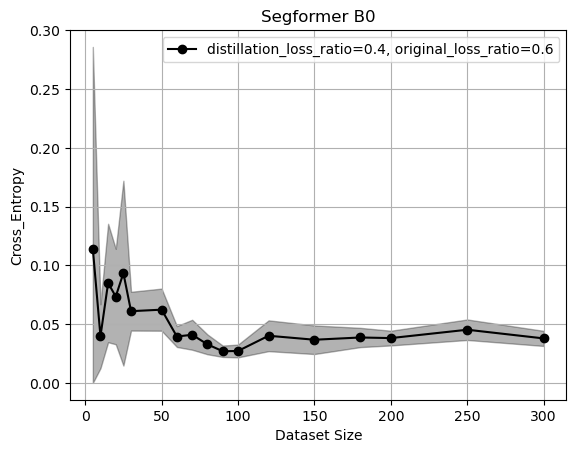

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()